# Homework 6

In [72]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

from typing import Tuple

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# the next cells, repeat code from earlier notebooks. It would be better to import these but
# then the notebook is no longer self-contained

### Copy of code from notebook

In [73]:
def pop_count32(x: np.uint32) -> np.uint8:
    """count the number of 1s in 32-bit integer x using Wegner's method
    
    Inputs:
    x - a 32 bit integer

    Returns:
    an integer between 0 and 32 indicating the number of 1s in x
    """
    
    count: np.uint8 = 0
    
    while (x > 0):
        x = x & (x-1)
        count += 1
        
    return count

In [74]:
def lfsr_step(state: np.uint32, fb: np.uint32, N: int = 31) -> Tuple[np.uint8, np.uint32]:
    """Single update step of LFSR with feedback connections fb
    
    Inputs:
    * state (uint32): initial state of the feedback shift register
    * fb (uint32): bit map indicating feedback connections; the LSB corresponds to bit 0 in the LFSR
    * N (int) order if the LFSR; must be less than 32 (default: 31)
    
    Returns:
    * elem - next element of the LFSR sequence
    * state - updated state
    
    Example: Generate the first 10 elements of a LFSR sequence with fb=0b1001 and initial state=0b1111
    >>> state = 0b1111
    >>> seq = np.empty(10, dtype=np.uint8)
    >>> for n in range(10):
    >>>     seq[n], state = lfsr31_step(state, 0b1001)
    >>> seq
    
    array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0], dtype=uint8)
    """
    
    # save the LSB before updating state; it will be returned
    elem: np.uint8 = state & 0b1
        
    # update state
    fb_vec: np.uint32 = state & fb
    fb_bit: np.uint8 = (pop_count32(fb_vec) & 0b1)
    
    # insert feedback bit at position N, then shift
    state = (state | fb_bit << N) >> 1
    
    return elem, state

In [75]:
def lfsr(init: np.uint32, fb: np.uint32, M: int, N: int = 31, Nc:int = 0):
    """Compute M samples of a LFSR sequence
    
    Inputs:
    init - initial state of the LFSR
    fb - feedback connection for the LFSR
    M - number of samples to generate
    N - order of the LFSR (default: 31)
    Nc - statrting sample (default 0)

    Returns:
    length-M vector of bits (stored as np.uint8)
    """
    seq = np.empty(M, dtype=np.uint8)

    state = init

    for n in range(Nc):
        _, state = lfsr_step(state, fb, N)          # discard the first Nc

    for n in range(M):  
        seq[n], state = lfsr_step(state, fb, N)     # keep the next Mc

    return seq

In [76]:
def random_symbols(A, N):
    """generate random symbols from the constallation A
    
    Inputs:
    A - np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N - number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

In [77]:
def srrc_pulse(a, fsT, N=5):
    """Construct a raised cosine pulse
    
    Inputs:
    a - roll-off factor
    fsT - number of samples per symbol period
    N - lenght of pulse in symbol periods; pulse ranges for -N \leq t/T \leq N (default: 5).

    Returns:
    Length 2*N*fsT+1 vector
    """
    # time axis with spacing 1/(fs*T)
    tt = np.linspace(-N, N, 2*N*fsT + 1)
    
    num = np.sin(np.pi*tt*(1-a)) + 4*a*tt*np.cos(np.pi*tt*(1+a))
    den = np.pi*tt*(1-(4*a*tt)**2)
    
    # deal with divide-by-zeros: at zero location, place "L'Hospital value" in numerator
    # and 1 in denominator.
    # First divide-by-zero location is t=0; by L-Hospital, the value is (1 + a*(4/pi - 1))
    ind_0 = np.where(np.abs(tt) < 1e-6)
    num[ind_0] = (1 + a*(4/np.pi - 1))
    den[ind_0] = 1
    # Second divide-by-zero location is t=+/-1/(4*a); by L-Hospital, the value is as shown below
    ind_0 = np.where(np.abs(np.abs(tt) - 1/(4*a)) < 1e-6)
    num[ind_0] = a/np.sqrt(2) * ((1+2/np.pi)*np.sin(np.pi/(4*a)) + (1-2/np.pi)*np.cos(np.pi/(4*a)))
    den[ind_0] = 1
    
    # scaling: we scale the pulse such that the convolution of two SRRC pulse yields
    # a RC pulse with amplitude 1 in the center of the pulse. This implies that
    # np.sum(hh**2) must equal 1. This replace the scaling by 1/T in the formula above.
    hh = num/den
    
    return hh / np.sqrt(np.sum(hh*hh))

In [78]:
def pulse_shape(symbols, pulse, fsT):
    """Generate a pulse-shaped QAM signal
    
    Inputs:
    symbols - a sequence of information symbols; rate 1/T
    pulse - sampled pulse shape; rate fsT/T
    fsT - samples per symbol period

    Returns:
    Numpy array with fsT*(len(symbols) - 1) + len(pulse)  samples
    """
    # step 1: upsample the symbol sequence
    up_symbols = np.zeros(fsT * (len(symbols) - 1) + 1, dtype=symbols.dtype)
    up_symbols[::fsT] = symbols

    # step 2: filter
    return np.convolve(up_symbols, pulse)

In [79]:
def MPE_decision_rule(Z, A):
    """Decide which symbol was most likely transmitted
    
    This function examines matched filter outputs (in vector Z) and for each element of Z selects the symbol 
    from constellation A that is closest.

    Inputs:
    Z - Vector of matched filter outputs
    A - Constellation

    Returns:
    Numpy array of the same length as Z
    """
    dec = np.empty_like(Z)

    for n in range(len(Z)):
        this_Z = Z[n]
        ind = np.argmin(np.abs(A-this_Z))
        dec[n] = A[ind]

    return dec

In [80]:
def est_freq(Z, pn, L=None):
    """Estimate frequency estimate from preamble samples

    Inputs:
    Z - matched filter outputs for preamble (taken at symbol period)
    pn - preamble sequence (same length as Z)
    L - spacing between samples to measure phase difference (default 2/3*K)

    Returns:
    float - frequency ofsset per symbol period
    """
    K = len(pn)

    if L is None:
        L = (2*K) // 3

    # make an array of all L-spaced phase differences
    dp = np.array( [ (pn[n+L]*Z[n+L]) * np.conj(pn[n]*Z[n]) for n in range(K-L) ] )

    return np.angle(np.mean(dp))/(2*L*np.pi)

## Problem 2

The code below generates a length-15 shift register sequence and computes the partial correlations $\frac{R^{(D)}}{X}$.

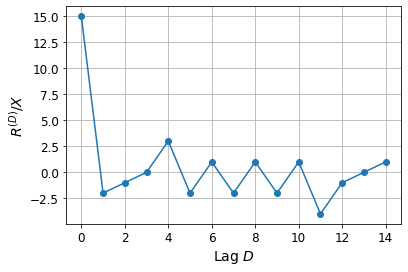

In [81]:
# make a shift register sequence, then turn it into BPSK symbols
pp = lfsr(init=1, fb=3, M=15, N=4)
A = np.array([1., -1.])
xx = A[pp]

# compute the partial correlations
r = np.zeros(15)
for n in range(15):
    r[n] = np.sum(xx[:15-n]*xx[n:])

# and plot them
plt.plot(r, '-o')
plt.grid()
plt.xlabel('Lag $D$')
plt.ylabel('$R^{(D)}/X$')

plt.show()

In [83]:
xx

array([-1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1., -1.,  1., -1.,
       -1., -1.])

Besides the large desired peak at lag $D=0$, there is a partial correlation with amplitude $-4$ at $D=11$.

## Problem 3:

In class, we discussed timing acquisition when all matched
filter outputs are available. In practice, acquisition must often
be performed sequentially. For each received sample, we must
compute (one sampling phase of $i$) one matched filter
output $Z_{n,i}$. Then, based on the matched filter output
$Z_{n,i}$, we should decide if we have found the end of the
preamble or not.

Modify the procedures discussed in class to implement a
sequential acquisition algorithm. Your algorithm should run
inside a `for` or `while` loop over the received
samoles that terminates
once the acquisition is complete.
    
For your algorithm, identify clearly
* What information must be stored by your algorithm?
* What are the steps to compute the matched filter outputs?
* What is your rule for deciding that you have found the
      preamble?
* Once you found the preamble, how do you estimate the
      frequency offset?
* How do you estimate the complex amplitude?

Demonstrate that your algorithm works by running it over the same
samples as the example in class.

**Answer:**

We begin copying the code that is needed to generate the received samples. The sequential receiver will pick up after that.

### Generate received signal

In [17]:
## construct a suitable training signal followed by information symbols
# Parameters
fsT = 32    # tx oversampling
K = 31      # length of preamble
fb = 5      # LFSR feedback

A = np.array([1.0, -1.0], dtype=complex)
Ns = 32     # number of information symbols

hh = srrc_pulse(0.5, fsT)

# make preamble symbols and info symbols, then concatenate
pn = A[lfsr(1, fb, K, 5)]
syms = random_symbols(A, Ns)

sig = pulse_shape(np.concatenate((pn, syms)), hh, fsT)

In [61]:
## channel parameters
delay_samples = 102
ds_factor = 4       # down-sample by 4

df = 0.1/(fsT*(K-1))  # frequency offset per symbol period, phase change is 0.1*2*pi over course of preamble
X = 0.5*np.exp(1j*np.pi/4) # amplitude and phase

# delay by pre-pending zeros
rr = np.concatenate(( np.zeros(delay_samples), 
                      X * sig * np.exp(2j * np.pi * df * np.arange(len(sig))),
                      np.zeros(delay_samples)))

# down-sample
rr = rr[::ds_factor]
fsT_r = fsT // ds_factor

SNR_dB = 20
SNR = 10**(SNR_dB/10)
noise_var = abs(X)**2 / SNR 

# the down-sampled signal should have higher amplitude  
rr = np.sqrt(ds_factor)*rr + np.sqrt(0.5 * noise_var) * (np.random.randn(len(rr)) + 1j*np.random.randn(len(rr))) 

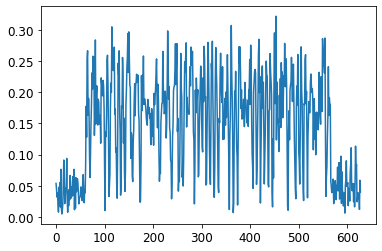

In [62]:
plt.plot(np.abs(rr))

### Receiver Processing

As the receiver has to maintain quite a bit of state information, we implement a class that encapsulates that state information. 

The receiver will process one sample at a time. Samples are matched filtered

In [69]:
SEARCH = 1
DEMOD = 2

class Receiver():
    """class representing a receiver
    
    Parameters:
    fsT - oversmapling factor
    hh - pulse shaping sequence
    pn - preamble sequence
    A - symbols alphabet

    State variables:
    state - either "SEARCH" or "DEMOD"A
    sr_samples - shift register to hold the past len(hh) samples
    sr_mf_out - shift registers for holding len(pn) MF outputs; one per sampling phase
    curr_phase - current sampling phase
    opt_phase - optimal sampling phase
    est_df - estimated frequency offset (per T)
    est_X - estimated complex amplitude at start of info symbols

    N_sym - number of symbols to demodulate; this variable keeps track of the number of symbols to decode
        it must be set before demod starts. If multiple bursts are
        processed, then it must be set new before each burst
    """

    def __init__(self, fsT, hh, pn, A):
        # store parameters
        self.fsT = fsT
        self.hh = np.flip(np.conj(hh))
        self.pn = pn
        self.A = A

        # initialize state
        self.N_h = len(hh)   # length of pulse shaping filter
        self.N_p = len(pn)        # length of preamble sequence
        self.state = SEARCH
        self.sr_samples = np.zeros(self.N_h, dtype=complex)
        self.sr_mf_out = np.zeros((fsT, self.N_p), dtype=complex)
        self.curr_phase = -1
        self.opt_phase = -1
        self.est_df = 0
        self.est_X = 0j

        self.N_sym = 0

        self._detected = False
        self._corr_max = 0
        self._threshold = 0.75
        self._n_demod = 0

        self._DEBUG = True

    def __call__(self, sample):
        """Process a new sample

        This is the main entry point. Each new sample is matched filtered. Then it is processed according to 
        the current state. 

        If we're still looking for the preamble, then the new sample is combined with other recent samples (stored 
        in self.sr_mf_out) to compute the correlation with the preamble sequence. Once the preamble is found, the state 
        changes to DEMOD.

        In the DEMOD state we only process samples from the correct phase. Phase corrections are applied and the
        MPE decision rule is used to recover symbols.
        
        Input:
        sample - a single baseband sample

        Returns:
        sym - if a new information symbol can be output, otherwise None
        """
        res = None # default return value

        # matched filter the new sample and update the sampling phase
        mf_out = self.mf(sample)
        self.curr_phase = (self.curr_phase + 1) % self.fsT

        if self.state == SEARCH:
            ## still looking for the preamble
            corr = self.corr_preamble(mf_out, self.curr_phase)

            # examine the correlation value; 
            if self.found_corr_peak(corr, self.curr_phase):
                # found the correlation peak, perform estimation and update state
                self.state = DEMOD
                # estimate frequency offset
                self.est_df = est_freq(self.sr_mf_out[self.opt_phase, :], self.pn)

                # and phasor
                Z_corr = self.sr_mf_out[self.opt_phase, :] * np.exp(-2j * np.pi * self.est_df * np.arange(self.N_p))
                ZZ_corr_pn = Z_corr * self.pn.conj()
                X_hat = np.sum(ZZ_corr_pn) / np.sum(np.abs(self.pn)**2)

                if self._DEBUG:
                    print("Found preamble on phase {:d}, correlation {:5.3f}".format(self.opt_phase, self._corr_max))
                    print('Estimated frequency offset: {:6.5f} (per T)'.format(self.est_df))
                    print("Estimated amplitude: {:4.3f}\nEstimated phase: {:4.3f} * pi".format(np.abs(X_hat), 
                                                                           np.angle(X_hat)/np.pi))

                # nearly done: set estimated phasor at beginning of SYMBOLS (this is where we should initialize a PLL)
                self.est_X = X_hat * np.exp(2j*np.pi * self.est_df * self.N_p)
                # and reset detector variables for next burst
                self._detected = False
                self._corr_max = 0
                self.sr_mf_out[:,:] = 0 # don't forget to clear the shift register!
                
            
        elif self.state == DEMOD:
            # looking to demod - if we're in the right sampling phase
            if self.curr_phase == self.opt_phase:
                # Compute phase correction - this should really be a PLL
                X_hat = self.est_X * np.exp(2j*np.pi * self.est_df * self._n_demod)

                # MPE_decision_rule doesn't take scalars; don't forget to apply correction
                dec = self.A[ np.argmin( np.abs( self.A - mf_out/X_hat ) )]
                
                # we have a symbol to return, set res - it will be returned at the end
                res = dec

                # update state
                self._n_demod += 1
                if self.N_sym == self._n_demod:
                    # got all symbols, back to search
                    self.state = SEARCH
                    if self._DEBUG:
                        print("demodulated {:d} symbols".format(self._n_demod))
                    self._n_demod = 0
        else:
            raise ValueError("Invalid State")


        return res

    def mf(self, sample):
        """produce a nw matched filter output"""

        # insert the new sample in the shift register for samples
        self.sr_samples[:self.N_h-1] = self.sr_samples[1:] # lose the oldest sample
        self.sr_samples[-1] = sample                       # insert new sample at end

        # filter (inner product)
        return np.sum(self.hh * self.sr_samples)

    
    def corr_preamble(self, mf_out, phase):
        """Compute correlation agains the preamble sequnece"""

        # insert mf_out in the shift register for this sampling phase
        self.sr_mf_out[phase, :self.N_p-1] = self.sr_mf_out[phase, 1:]
        self.sr_mf_out[phase, -1] = mf_out

        # compute correlation; we use the normalized correlation that produces values between 0 and 1
        Num = np.abs( np.sum(self.sr_mf_out[phase, :] * self.pn) )**2
        D1 = np.real( np.sum(self.sr_mf_out[phase, :] * np.conj(self.sr_mf_out[phase, :])) )
        D2 = np.real( np.sum(self.pn * np.conj(self.pn)) )

        return Num / (D1 * D2)

    def found_corr_peak(self, corr, phase):
        """Examine the correlation and update state as needed"""
        found_peak = False

        if corr > self._threshold and not self._detected:
            # this is the first time over the threshold, take note
            self._detected = True
            self._corr_max = corr
            self.opt_phase = self.curr_phase
        elif self._detected:
            # we have been above the threshold recently
            # is this sample bigger than what we had before?
            if corr > self._corr_max:
                self._corr_max = corr
                self.opt_phase = phase
            else:
                # no improvement, let's assume we have seen the correlation peak
                # the opt_phase is whatever was found - no update
                found_peak = True

        return found_peak


The receiver object encapsulates all the processing. Hence, the actual processing of received samples is easy.

In [71]:
## parameters for the receiver
fsT_r = fsT // ds_factor
hh_r = srrc_pulse(0.5, fsT_r)  # filter for reduced sampling rate

# instantiate the Receiver object
rx = Receiver(fsT_r, hh_r, pn, A)

# tell the receiver, how many symbols to expect
rx.N_sym = len(syms) # let the rx know how many symbols we need

# set up storage for received symbols
rx_syms = np.zeros_like(syms)
m = 0

# invoke the receiver one sample at a time
for n in range(len(rr)):
    sym = rx(rr[n])
    if sym is not None:
        # most of the time, the receiver returns `None`, except when we have a symbol
        rx_syms[m] = sym
        m += 1

print("Found {:d} errors".format(np.sum(np.not_equal(rx_syms, syms))))


Found preamble on phase 1, correlation 0.952
Estimated frequency offset: 0.00331 (per T)
Estimated amplitude: 0.499
Estimated phase: 0.279 * pi
demodulated 32 symbols
Found 0 errors
